In [1]:
import os
import sys
import torch
import numpy as np
import torch.nn as nn
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt

cwd = os.getcwd()
module_path = "/".join(cwd.split('/')[0:-1])
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn import datasets
from utils import gmm_utils
from net.spectral_normalization.spectral_norm_fc import spectral_norm_fc
from metrics.uncertainty_confidence import entropy
from utils.train_utils import train_single_epoch, test_single_epoch
from utils.ensemble_utils import ensemble_forward_pass

In [2]:
_ACTIVATIONS = {
    'relu': nn.ReLU(),
    'elu': nn.ELU()
}

device = "cuda" if torch.cuda.is_available() else "cpu"

class FCResNet(nn.Module):
    def __init__(
        self,
        input_dim,
        features,
        depth,
        spectral_normalization,
        coeff=0.95,
        n_power_iterations=1,
        dropout_rate=0.01,
        activation='relu'
    ):
        super().__init__()

        # ResFNN architecture from google paper: https://arxiv.org/abs/2006.10108
        self.first = nn.Linear(input_dim, features)
        self.residuals = nn.ModuleList(
            [nn.Linear(features, features) for i in range(depth)]
        )
        self.dropout = nn.Dropout(dropout_rate)

        if spectral_normalization:
            self.first = spectral_norm_fc(
                self.first, coeff=coeff, n_power_iterations=n_power_iterations
            )

            for i in range(len(self.residuals)):
                self.residuals[i] = spectral_norm_fc(
                    self.residuals[i],
                    coeff=coeff,
                    n_power_iterations=n_power_iterations,
                )
        self.last = nn.Linear(features, 2)

        self.activation = _ACTIVATIONS.get(activation)
        if self.activation is None:
            raise NotImplementedError(f"{activation} is not a valid option. Choose from ['relu, 'elu']")


    def forward(self, x):
        x = self.first(x)
        for residual in self.residuals:
            x = x + self.dropout(self.activation(residual(x)))
        self.feature = x
        x = self.last(x)
        return x

In [3]:
np.random.seed(0)
torch.manual_seed(0)

noise = 0.1
batch_size = 64

X_train, y_train = datasets.make_moons(n_samples=2000, noise=noise)
X_test, y_test = datasets.make_moons(n_samples=200, noise=noise)

ds_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train))
dl_train_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=True)

dl_train_no_drop_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=False, drop_last=False)

ds_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test))
dl_test_loader = torch.utils.data.DataLoader(ds_test, batch_size=200, shuffle=False)

input_dim = X_train.shape[1]
num_classes = 2

In [4]:
features = 128
depth = 4
coeff = 0.65
n_power_iterations = 5

spectral_normalization = False
dropout_rate = 0.0

n_ensemble = 3

model_ensemble = [FCResNet(
    input_dim=input_dim,
    features=features,
    depth=depth,
    spectral_normalization=spectral_normalization,
    coeff=coeff,
    n_power_iterations=n_power_iterations,
    dropout_rate=dropout_rate
).to(device) for i in range(n_ensemble)]

print (model_ensemble[0])

FCResNet(
  (first): Linear(in_features=2, out_features=128, bias=True)
  (residuals): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (last): Linear(in_features=128, out_features=2, bias=True)
  (activation): ReLU()
)


In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizers = [
    torch.optim.Adam(model_ensemble[i].parameters()) for i in range(n_ensemble)
]
num_epochs = 5

In [6]:
# Training the ensemble of FC ResNets
for epoch in range(num_epochs):
    for i, model in enumerate(model_ensemble):
        print ("Ensemble model: " + str(i))
        train_loss = train_single_epoch(
            epoch, model, dl_train_loader, optimizers[i], device
        )

Ensemble model: 0
Train Epoch: 0 [0/1984 (0%)]	Loss: 1.141410
Train Epoch: 0 [640/1984 (32%)]	Loss: 0.224662
Train Epoch: 0 [1280/1984 (65%)]	Loss: 0.186688
Train Epoch: 0 [1920/1984 (97%)]	Loss: 0.128561
====> Epoch: 0 Average loss: 0.0044
Ensemble model: 1
Train Epoch: 0 [0/1984 (0%)]	Loss: 0.763293
Train Epoch: 0 [640/1984 (32%)]	Loss: 0.178700
Train Epoch: 0 [1280/1984 (65%)]	Loss: 0.311694
Train Epoch: 0 [1920/1984 (97%)]	Loss: 0.115386
====> Epoch: 0 Average loss: 0.0039
Ensemble model: 2
Train Epoch: 0 [0/1984 (0%)]	Loss: 0.587230
Train Epoch: 0 [640/1984 (32%)]	Loss: 0.177205
Train Epoch: 0 [1280/1984 (65%)]	Loss: 0.111804
Train Epoch: 0 [1920/1984 (97%)]	Loss: 0.066701
====> Epoch: 0 Average loss: 0.0032
Ensemble model: 0
Train Epoch: 1 [0/1984 (0%)]	Loss: 0.133269
Train Epoch: 1 [640/1984 (32%)]	Loss: 0.106636
Train Epoch: 1 [1280/1984 (65%)]	Loss: 0.045631
Train Epoch: 1 [1920/1984 (97%)]	Loss: 0.029579
====> Epoch: 1 Average loss: 0.0013
Ensemble model: 1
Train Epoch: 1 [0/

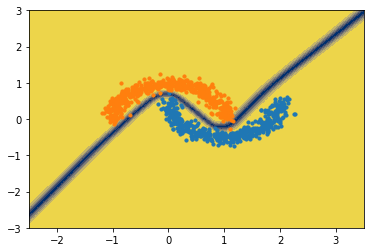

In [7]:
# Visualising softmax entropy
for model in model_ensemble:
    model.eval()

single_model = model_ensemble[1]

domain = 3
x_lin = np.linspace(-domain+0.5, domain+0.5, 100)
y_lin = np.linspace(-domain, domain, 100)

xx, yy = np.meshgrid(x_lin, y_lin)
X_grid = np.column_stack([xx.flatten(), yy.flatten()])

X_vis, y_vis = datasets.make_moons(n_samples=1000, noise=noise)
mask = y_vis.astype(bool)

X_grid = torch.from_numpy(X_grid).float().to(device)

with torch.no_grad():
    output = single_model(X_grid)
    uncertainty = entropy(output)

z = - uncertainty.cpu().numpy().reshape(xx.shape)

plt.figure()
plt.contourf(x_lin, y_lin, z, cmap='cividis')

plt.scatter(X_vis[mask,0], X_vis[mask,1], s=10)
plt.scatter(X_vis[~mask,0], X_vis[~mask,1], s=10)
plt.savefig("two_moons_softmax_entropy_no_sn.png", bbox_inches="tight")
plt.savefig("two_moons_softmax_entropy_no_sn.pdf", bbox_inches="tight")

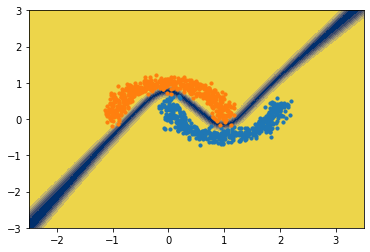

In [8]:
# Visualising predictive entropy
domain = 3
x_lin = np.linspace(-domain+0.5, domain+0.5, 100)
y_lin = np.linspace(-domain, domain, 100)

xx, yy = np.meshgrid(x_lin, y_lin)
X_grid = np.column_stack([xx.flatten(), yy.flatten()])

X_vis, y_vis = datasets.make_moons(n_samples=1000, noise=noise)
mask = y_vis.astype(bool)

X_grid = torch.from_numpy(X_grid).float().to(device)

with torch.no_grad():
    output, uncertainty, _ = ensemble_forward_pass(model_ensemble, X_grid)

z = - uncertainty.cpu().numpy().reshape(xx.shape)

plt.figure()
plt.contourf(x_lin, y_lin, z, cmap='cividis')

plt.scatter(X_vis[mask,0], X_vis[mask,1], s=10)
plt.scatter(X_vis[~mask,0], X_vis[~mask,1], s=10)

plt.savefig("two_moons_predictive_entropy_no_sn.png", bbox_inches="tight")
plt.savefig("two_moons_predictive_entropy_no_sn.pdf", bbox_inches="tight")

In [9]:
# Train FC ResNet with spectral normalization

features = 128
depth = 4
coeff = 0.65
n_power_iterations = 5

spectral_normalization = True
dropout_rate = 0.0

model = FCResNet(
    input_dim=input_dim,
    features=features,
    depth=depth,
    spectral_normalization=spectral_normalization,
    coeff=coeff,
    n_power_iterations=n_power_iterations,
    dropout_rate=dropout_rate
).to(device)

print (model)

FCResNet(
  (first): Linear(in_features=2, out_features=128, bias=True)
  (residuals): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (last): Linear(in_features=128, out_features=2, bias=True)
  (activation): ReLU()
)


In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 150

In [11]:
# Training the ensemble of FC ResNets
for epoch in range(num_epochs):
    train_loss = train_single_epoch(
        epoch, model, dl_train_loader, optimizer, device
    )

Train Epoch: 0 [0/1984 (0%)]	Loss: 0.660564
Train Epoch: 0 [640/1984 (32%)]	Loss: 0.583091
Train Epoch: 0 [1280/1984 (65%)]	Loss: 0.449884
Train Epoch: 0 [1920/1984 (97%)]	Loss: 0.435066
====> Epoch: 0 Average loss: 0.0084
Train Epoch: 1 [0/1984 (0%)]	Loss: 0.378749
Train Epoch: 1 [640/1984 (32%)]	Loss: 0.350785
Train Epoch: 1 [1280/1984 (65%)]	Loss: 0.406387
Train Epoch: 1 [1920/1984 (97%)]	Loss: 0.314573
====> Epoch: 1 Average loss: 0.0055
Train Epoch: 2 [0/1984 (0%)]	Loss: 0.328401
Train Epoch: 2 [640/1984 (32%)]	Loss: 0.287965
Train Epoch: 2 [1280/1984 (65%)]	Loss: 0.348256
Train Epoch: 2 [1920/1984 (97%)]	Loss: 0.255123
====> Epoch: 2 Average loss: 0.0048
Train Epoch: 3 [0/1984 (0%)]	Loss: 0.250969
Train Epoch: 3 [640/1984 (32%)]	Loss: 0.288830
Train Epoch: 3 [1280/1984 (65%)]	Loss: 0.261940
Train Epoch: 3 [1920/1984 (97%)]	Loss: 0.252808
====> Epoch: 3 Average loss: 0.0044
Train Epoch: 4 [0/1984 (0%)]	Loss: 0.261587
Train Epoch: 4 [640/1984 (32%)]	Loss: 0.351348
Train Epoch: 4 [1

Train Epoch: 36 [1920/1984 (97%)]	Loss: 0.172579
====> Epoch: 36 Average loss: 0.0026
Train Epoch: 37 [0/1984 (0%)]	Loss: 0.220616
Train Epoch: 37 [640/1984 (32%)]	Loss: 0.112979
Train Epoch: 37 [1280/1984 (65%)]	Loss: 0.204004
Train Epoch: 37 [1920/1984 (97%)]	Loss: 0.163981
====> Epoch: 37 Average loss: 0.0025
Train Epoch: 38 [0/1984 (0%)]	Loss: 0.190393
Train Epoch: 38 [640/1984 (32%)]	Loss: 0.193478
Train Epoch: 38 [1280/1984 (65%)]	Loss: 0.078215
Train Epoch: 38 [1920/1984 (97%)]	Loss: 0.165409
====> Epoch: 38 Average loss: 0.0026
Train Epoch: 39 [0/1984 (0%)]	Loss: 0.123539
Train Epoch: 39 [640/1984 (32%)]	Loss: 0.169357
Train Epoch: 39 [1280/1984 (65%)]	Loss: 0.116744
Train Epoch: 39 [1920/1984 (97%)]	Loss: 0.135234
====> Epoch: 39 Average loss: 0.0023
Train Epoch: 40 [0/1984 (0%)]	Loss: 0.142044
Train Epoch: 40 [640/1984 (32%)]	Loss: 0.088272
Train Epoch: 40 [1280/1984 (65%)]	Loss: 0.110089
Train Epoch: 40 [1920/1984 (97%)]	Loss: 0.151809
====> Epoch: 40 Average loss: 0.0024
Tr

Train Epoch: 72 [1920/1984 (97%)]	Loss: 0.074535
====> Epoch: 72 Average loss: 0.0010
Train Epoch: 73 [0/1984 (0%)]	Loss: 0.068140
Train Epoch: 73 [640/1984 (32%)]	Loss: 0.066683
Train Epoch: 73 [1280/1984 (65%)]	Loss: 0.127709
Train Epoch: 73 [1920/1984 (97%)]	Loss: 0.045397
====> Epoch: 73 Average loss: 0.0010
Train Epoch: 74 [0/1984 (0%)]	Loss: 0.068157
Train Epoch: 74 [640/1984 (32%)]	Loss: 0.038318
Train Epoch: 74 [1280/1984 (65%)]	Loss: 0.068306
Train Epoch: 74 [1920/1984 (97%)]	Loss: 0.064632
====> Epoch: 74 Average loss: 0.0010
Train Epoch: 75 [0/1984 (0%)]	Loss: 0.083699
Train Epoch: 75 [640/1984 (32%)]	Loss: 0.047419
Train Epoch: 75 [1280/1984 (65%)]	Loss: 0.042518
Train Epoch: 75 [1920/1984 (97%)]	Loss: 0.062367
====> Epoch: 75 Average loss: 0.0010
Train Epoch: 76 [0/1984 (0%)]	Loss: 0.068141
Train Epoch: 76 [640/1984 (32%)]	Loss: 0.051992
Train Epoch: 76 [1280/1984 (65%)]	Loss: 0.120516
Train Epoch: 76 [1920/1984 (97%)]	Loss: 0.064788
====> Epoch: 76 Average loss: 0.0010
Tr

Train Epoch: 108 [1920/1984 (97%)]	Loss: 0.039204
====> Epoch: 108 Average loss: 0.0005
Train Epoch: 109 [0/1984 (0%)]	Loss: 0.028589
Train Epoch: 109 [640/1984 (32%)]	Loss: 0.027494
Train Epoch: 109 [1280/1984 (65%)]	Loss: 0.073814
Train Epoch: 109 [1920/1984 (97%)]	Loss: 0.056628
====> Epoch: 109 Average loss: 0.0006
Train Epoch: 110 [0/1984 (0%)]	Loss: 0.064858
Train Epoch: 110 [640/1984 (32%)]	Loss: 0.046731
Train Epoch: 110 [1280/1984 (65%)]	Loss: 0.045407
Train Epoch: 110 [1920/1984 (97%)]	Loss: 0.071925
====> Epoch: 110 Average loss: 0.0006
Train Epoch: 111 [0/1984 (0%)]	Loss: 0.037800
Train Epoch: 111 [640/1984 (32%)]	Loss: 0.042021
Train Epoch: 111 [1280/1984 (65%)]	Loss: 0.037903
Train Epoch: 111 [1920/1984 (97%)]	Loss: 0.029890
====> Epoch: 111 Average loss: 0.0006
Train Epoch: 112 [0/1984 (0%)]	Loss: 0.014813
Train Epoch: 112 [640/1984 (32%)]	Loss: 0.018630
Train Epoch: 112 [1280/1984 (65%)]	Loss: 0.018287
Train Epoch: 112 [1920/1984 (97%)]	Loss: 0.018812
====> Epoch: 112 A

Train Epoch: 144 [1920/1984 (97%)]	Loss: 0.048250
====> Epoch: 144 Average loss: 0.0003
Train Epoch: 145 [0/1984 (0%)]	Loss: 0.050504
Train Epoch: 145 [640/1984 (32%)]	Loss: 0.018548
Train Epoch: 145 [1280/1984 (65%)]	Loss: 0.020607
Train Epoch: 145 [1920/1984 (97%)]	Loss: 0.016392
====> Epoch: 145 Average loss: 0.0003
Train Epoch: 146 [0/1984 (0%)]	Loss: 0.036506
Train Epoch: 146 [640/1984 (32%)]	Loss: 0.016026
Train Epoch: 146 [1280/1984 (65%)]	Loss: 0.030340
Train Epoch: 146 [1920/1984 (97%)]	Loss: 0.021115
====> Epoch: 146 Average loss: 0.0004
Train Epoch: 147 [0/1984 (0%)]	Loss: 0.035895
Train Epoch: 147 [640/1984 (32%)]	Loss: 0.019268
Train Epoch: 147 [1280/1984 (65%)]	Loss: 0.026358
Train Epoch: 147 [1920/1984 (97%)]	Loss: 0.014084
====> Epoch: 147 Average loss: 0.0003
Train Epoch: 148 [0/1984 (0%)]	Loss: 0.024125
Train Epoch: 148 [640/1984 (32%)]	Loss: 0.012229
Train Epoch: 148 [1280/1984 (65%)]	Loss: 0.017689
Train Epoch: 148 [1920/1984 (97%)]	Loss: 0.017396
====> Epoch: 148 A

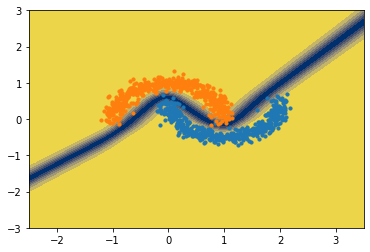

In [12]:
# Visualising softmax entropy
model.eval()

domain = 3
x_lin = np.linspace(-domain+0.5, domain+0.5, 100)
y_lin = np.linspace(-domain, domain, 100)

xx, yy = np.meshgrid(x_lin, y_lin)
X_grid = np.column_stack([xx.flatten(), yy.flatten()])

X_vis, y_vis = datasets.make_moons(n_samples=1000, noise=noise)
mask = y_vis.astype(bool)

X_grid = torch.from_numpy(X_grid).float().to(device)

with torch.no_grad():
    output = model(X_grid)
    uncertainty = entropy(output)

z = - uncertainty.cpu().numpy().reshape(xx.shape)

plt.figure()
plt.contourf(x_lin, y_lin, z, cmap='cividis')

plt.scatter(X_vis[mask,0], X_vis[mask,1], s=10)
plt.scatter(X_vis[~mask,0], X_vis[~mask,1], s=10)
plt.savefig("two_moons_softmax_entropy_sn.png", bbox_inches="tight")
plt.savefig("two_moons_softmax_entropy_sn.pdf", bbox_inches="tight")

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
embeddings, labels = gmm_utils.get_embeddings(model, dl_train_no_drop_loader, features, torch.double, device, device)

gda, jitter_eps = gmm_utils.gmm_fit(embeddings, labels, 2)
jitter_eps

100%|██████████| 32/32 [00:00<00:00, 494.48it/s]


0

In [14]:
train_log_probs_B_Y, train_labels = gmm_utils.gmm_evaluate(model, gda, dl_train_no_drop_loader, device, 2, device)

100%|██████████| 32/32 [00:00<00:00, 403.32it/s]


In [15]:
train_densities = torch.logsumexp(train_log_probs_B_Y, dim=-1)
train_min_density = train_densities.min().item()
train_median_density = torch.mean(train_densities).item()

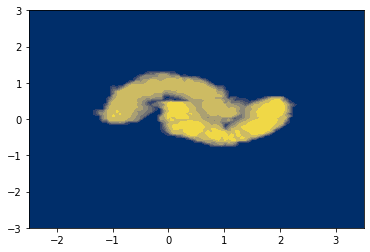

In [16]:
model.eval()

domain = 3
x_lin = np.linspace(-domain+0.5, domain+0.5, 100)
y_lin = np.linspace(-domain, domain, 100)

xx, yy = np.meshgrid(x_lin, y_lin)
X_grid = np.column_stack([xx.flatten(), yy.flatten()])

X_vis, y_vis = datasets.make_moons(n_samples=1000, noise=noise)
mask = y_vis.astype(bool)
            
X_grid = torch.from_numpy(X_grid).float()
X_grid = X_grid.cuda() if torch.cuda.is_available() else X_grid

with torch.no_grad():
    log_probs_B_Y = gmm_utils.gmm_forward(model, gda, X_grid.cuda())
    density = torch.logsumexp(log_probs_B_Y, dim=-1) - train_min_density
    uncertainty = density
        
z = uncertainty.cpu().numpy().reshape(xx.shape)

z_ood_percentiles = np.percentile(z[z<0],[0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
z_id_percentiles = np.percentile(z[z>=0],[0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

zmin = z[np.isfinite(z)].min()
zmax = z[np.isfinite(z)].max()
z[z==np.inf] = zmax
z[z==-np.inf] = zmin

plt.figure()
plt.contourf(x_lin, y_lin, np.clip(z,-1, zmax)/zmax, cmap='cividis')

plt.savefig("two_moons_ddu_sn.png", bbox_inches="tight")
plt.savefig("two_moons_ddu_sn.pdf", bbox_inches="tight")